In [ ]:
!pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
from numpy import nan
from sklearn.model_selection import GridSearchCV

# **Project 1 : Basketball 2015**

홈팀의 우승을 맞추는 것이므로 prediction concepts은 분류(classification)이다, regression은 사용 x

In [ ]:
#파일 불러들여오기
basketball = pd.read_csv('basketball.csv')
#결측값 있는 지 확인
basketball.isnull().sum()

Date            0
Visitor Team    0
VisitorPts      0
Home Team       0
HomePts         0
Attend.         0
dtype: int64

In [ ]:
basketball.rename(columns = {'Visitor Team' : 'Visitor_Team','Home Team' :'Home_Team'}, inplace = True)

## **해당 시즌 우승팀**

In [ ]:
#점수를 바탕으로 winner를 만들어준다 (해당시즌 우승팀을 알기위해서)
basketball['Winner'] = np.where(basketball['VisitorPts']>basketball['HomePts'],basketball['Visitor_Team'], basketball['Home_Team'])

basketball['Winner'].value_counts()

Golden State Warriors     88
Cleveland Cavaliers       73
San Antonio Spurs         73
Toronto Raptors           66
Oklahoma City Thunder     66
Miami Heat                55
Los Angeles Clippers      55
Atlanta Hawks             52
Charlotte Hornets         51
Boston Celtics            50
Portland Trail Blazers    49
Indiana Pacers            48
Detroit Pistons           44
Dallas Mavericks          43
Chicago Bulls             42
Houston Rockets           42
Memphis Grizzlies         42
Washington Wizards        41
Utah Jazz                 40
Orlando Magic             35
Sacramento Kings          33
Milwaukee Bucks           33
Denver Nuggets            33
New York Knicks           32
New Orleans Pelicans      30
Minnesota Timberwolves    29
Phoenix Suns              23
Brooklyn Nets             21
Los Angeles Lakers        17
Philadelphia 76ers        10
Name: Winner, dtype: int64

해당 시즌 우승팀은 88번의 승리로 'Golden State Warriors'이다 

## **데이터 전처리**

In [ ]:
#점수를 바탕으로 Home팀이 이겼는지 아닌지 나타내는 열
basketball['Homewin'] = np.where(basketball['HomePts']>basketball['VisitorPts'], 1, 0) # True:1, False:0

basketball['Date'] = pd.to_datetime(basketball['Date']) 

#날짜에서 년도를 따로 빼주기
basketball['Year'] = basketball['Date'].dt.year 

#날짜에서 달을 따로 빼주기
basketball['Month'] = basketball['Date'].dt.month

#날짜에서 요일을 따로 빼주기 
basketball['Weekday'] = basketball['Date'].dt.weekday # 월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6

#holiday 변수 만들어주기
holiday_list = basketball['Date']
us_holidays = holidays.US()
basketball['ds'] = sorted(holiday_list)
basketball['Holiday'] = basketball.ds.apply(lambda x: 1 if x in us_holidays else 0) #True:1, False:0

basketball.loc[basketball.Weekday > 4, 'Holiday'] = 1 # 토,일은 휴일이니까 

In [ ]:
basketball.head()

,Date,Visitor_Team,VisitorPts,Home_Team,HomePts,Attend.,Winner,Homewin,Year,Month,Weekday,ds,Holiday
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,21957,Chicago Bulls,1,2015,10,1,2015-10-27,0
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,19187,Detroit Pistons,0,2015,10,1,2015-10-27,0
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,19596,Golden State Warriors,1,2015,10,1,2015-10-27,0
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,18846,Washington Wizards,0,2015,10,2,2015-10-28,0
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,18624,Boston Celtics,1,2015,10,2,2015-10-28,0


In [ ]:
#homewin변수를 만들어줬으므로 winner을 삭제, date의 관한 변수들을 따로 만들어 줫으니 date도 삭제, holiday변수를 만들기 위해 만들었던 
#ds 변수도 삭제, 각 팀의 점수들은 경기 하기 전 알 수 없으므로 삭제해 basketball_df를 만들어줬다
basketball_df = basketball.drop(columns = ['Date', 'VisitorPts','HomePts','ds','Winner'])

## **원핫인코딩**

In [ ]:
enc = OneHotEncoder(sparse=False)
# fit_transform은 train에만 사용하고 test에는 학습된 인코더에 fit만 해야한다

cats = ['Visitor_Team','Home_Team']
out_enc = enc.fit_transform(basketball_df[cats])
new_cols = enc.get_feature_names_out(cats).tolist()

In [ ]:
df_enc = pd.DataFrame(data = out_enc, columns = new_cols)
df_enc.index = basketball_df.index

basketball_df.drop(cats, axis=1, inplace=True)
basketball_df = pd.concat([basketball_df,df_enc],axis=1)

In [ ]:
X = basketball_df.drop(columns=['Homewin'])
y = basketball[['Homewin']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

## **hometeam 우승 가설 세우기 위한 과정**

In [ ]:
basketball['Holiday'].value_counts()

0    923
1    393
Name: Holiday, dtype: int64

In [ ]:
homewin = basketball['Homewin'] == 1
visitorwin = basketball['Homewin'] == 0

#홈팀이 우승한 결과만 나타내는 hw_df
hw_df = basketball.loc[homewin,:]

#비지터팀이 우승한 결과만 나타내는 visitorwin_df
visitorwin_df = basketball.loc[visitorwin,:]

print("hw_df.shape",hw_df.shape) # 홈팀은 우승 : 782번
print("vs_df.shape",visitorwin_df.shape) # 비지터팀은 우승 : 534번

hw_df.shape (782, 13)
vs_df.shape (534, 13)


홈팀에 대한 분석

In [ ]:
print("hw_df: Holiday", hw_df['Holiday'].value_counts())
print("hw_df: year", hw_df['Year'].value_counts())
print("hw_df: Month", hw_df['Month'].value_counts())
print("hw_df: mean(Attend.)", hw_df['Attend.'].mean())
print("hw_df: max(Attend.)", hw_df['Attend.'].max())
print("hw_df: min(Attend.)", hw_df['Attend.'].min())

hw_df: Holiday 0    543
1    239
Name: Holiday, dtype: int64
hw_df: year 2016    491
2015    291
Name: Year, dtype: int64
hw_df: Month 3     151
11    139
12    135
1     134
2      90
4      87
5      25
10     17
6       4
Name: Month, dtype: int64
hw_df: mean(Attend.) 18210.61381074169
hw_df: max(Attend.) 23143
hw_df: min(Attend.) 9153


비지터 팀에 대한 분석

In [ ]:
print("vs_df: Holiday", visitorwin_df['Holiday'].value_counts())
print("vs_df: Year", visitorwin_df['Year'].value_counts())
print("vs_df: Month", visitorwin_df['Month'].value_counts())
print("vs_df: mean(Attend.)", visitorwin_df['Attend.'].mean())
print("vs_df: max(Attend.)", visitorwin_df['Attend.'].max())
print("vs_df: min(Attend.)", visitorwin_df['Attend.'].min())

vs_df: Holiday 0    380
1    154
Name: Holiday, dtype: int64
vs_df: Year 2016    336
2015    198
Name: Year, dtype: int64
vs_df: Month 1     96
12    93
3     86
11    84
2     81
4     59
10    21
5     11
6      3
Name: Month, dtype: int64
vs_df: mean(Attend.) 17618.04307116105
vs_df: max(Attend.) 23152
vs_df: min(Attend.) 9722


홈팀이 우승한 결과에 대해 나타내는 hw_df를 만들어주었고

visitor팀이 우승한 결과에 대해 나타내는 visitorwin_df를 만들어주었다

전체에서 홈팀이 782번의 우승을 하였고, 비지터팀이 534번의 우승을 하였다

홈팀은 non-holiday : holiday의 비율이 2.272:1 이었고 비지터팀은 2.468:1 이었다 

전체 데이터의 non-holiday : holiday의 비율이 2.3486 :1 이므로 비지터팀보다 holiday일수록 우승할 확률이 높다

홈팀은 년도는 2016년에 우승을 많이 하였고 달로는 3월에 제일 많이 하였다 3월에 한 우승은 다 2016년도에 한 우승이므로

홈팀은 2016년 3월에 하는 경기일수록 우승을 할 확률이 높다 

관중수는 우승에 큰 영향을 미치는 것 같지는 않다

## **모델 돌리기 LogisticRegression**

In [ ]:
flf =  LogisticRegression( multi_class='ovr',C=0.04, max_iter=10000)
flf.fit(X_train,y_train)
y_pred = flf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1 score is = " + str(f1))

f1 score is = 0.7737003058103975


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Project 2: Adult data**

In [ ]:
colNames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '50k']

#데이터 불러오기
adult = pd.read_csv('adult.data',names=colNames, index_col=False)
adult['Earnings-Raw'] = np.where(adult['50k'] == " <=50K", 0, 1) #0 : "<=50K" 1: ">50K" 

범주형 변수 value_counts()

?가 포함된 열 
occupation: 1843행, native-country:583행, workcalss:1836 근데 결측값은 없다

adult['50k']에서 <=50k : >50k는 0.75:0.25이다

race, native-country, workclass는 한쪽으로 치우진 경우가 많다

연속형 변수: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week 

범주형 변수: marital-status, occupation, relationship, workclass, race -> 원핫인코딩 해주기
            
education은 education-num이 설명할 수 있다 생각하기 때문에 삭제한다

native-country은 race가 설명할 수 있다 생각하기 때문에 삭제한다 

이진형 변수: sex -> female:0, male:1로 대체

종속변수 : over50k : 1: >50k , 0: <=50k 

## **데이터 전처리**

In [ ]:
# ?로 되어있는 값 결측값으로 바꾼다
adult = adult.replace(' ?',nan)

print(adult.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
50k                  0
Earnings-Raw         0
dtype: int64


In [ ]:
#최빈값으로 결측값 대체하기 

adult['native-country'].fillna(adult['native-country'].mode()[0],inplace = True)
adult['workclass'].fillna(adult['workclass'].mode()[0],inplace = True)
adult['occupation'].fillna(adult['occupation'].mode()[0],inplace = True)

In [ ]:
#결측값 없어짐

adult.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
50k               0
Earnings-Raw      0
dtype: int64

## **상관관계를 기준으로 변수 선택**

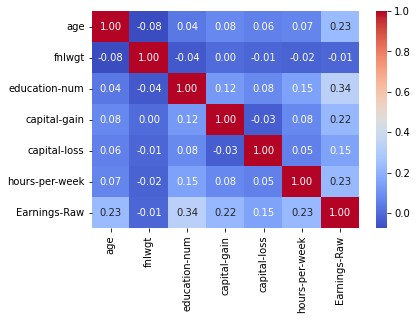

In [ ]:
numeric_features = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week','Earnings-Raw']
sns.heatmap(adult[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

다른 변수들과 다르게 fnlwgt와 Earning-Raw는 0.01로 상관관계가 매우 낮았지만 변수에서 삭제하면 f1 score가 낮아지기 때문에 삭제 안 하기로 한다 ...

In [ ]:
adult['sex'] = np.where(adult['sex'] == ' Male', 1, 0) #male은 1로 female은 0으로 바꿔준다
adult_df = adult.drop(columns = ['50k']) #50k인지 아닌지 이진형으로 만든 변수(over50k)를 생성했기 때문에 50k 변수를 삭제해준다

#marital-status변수는 single과 married로 이진형변수로 만들어준다음에 1,0의 값으로 바꿔준다

adult_df["marital-status"] = adult_df["marital-status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
adult_df["marital-status"] = adult_df["marital-status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
adult_df['marital-status'] = np.where(adult_df["marital-status"] == 'Married',1,0) # Married:1, single:0

#race만으로 충분히 설명가능하므로 native-country도 변수에서 제거해준다 
#educatioin-num만으로도 충분히 설명가능하므로 education도 변수에서 제거해준다

adult_df.drop(labels=["native-country"], axis = 1, inplace = True) 
adult_df.drop(labels=["education"], axis = 1, inplace = True) 

## **원핫인코딩**

In [ ]:
ohc = OneHotEncoder(sparse=False)

dogs = ['workclass', 'occupation', 'relationship', 'race']

out_ohc = ohc.fit_transform(adult_df[dogs])
new_col = ohc.get_feature_names_out(dogs).tolist()

In [ ]:
df_ohc = pd.DataFrame(data = out_ohc, columns = new_col)
df_ohc.index = adult_df.index

adult_df.drop(dogs,axis=1,inplace=True)
adult_df = pd.concat([adult_df,df_ohc],axis=1)

In [ ]:
from sklearn.preprocessing import *

X = adult_df.drop(columns=['Earnings-Raw']) 
y = adult_df[['Earnings-Raw']]

#값들간 표준편차가 많이 차이나는 'capital-gain', 'capital-loss'는 minmascaler로 값변환을 해준다 
scaler = MinMaxScaler()
X[['capital-gain', 'capital-loss']] = scaler.fit_transform(X[['capital-gain', 'capital-loss']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

## **GridSearch**

In [ ]:
params ={
    'n_estimators':[100],
    'max_depth':[6,8,10,12,None],
    'min_samples_leaf':[1,4,8,12],
    'min_samples_split':[2,8,16,20]
}

In [ ]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12, None],
                         'min_samples_leaf': [1, 4, 8, 12],
                         'min_samples_split': [2, 8, 16, 20],
                         'n_estimators': [100]})

In [ ]:
print('Best score is = ', str(grid_cv.best_score_))

Best score is =  0.8607380744339523


In [ ]:
print('Best parameter are = ', str(grid_cv.best_params_))

Best parameter are =  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
flf =  RandomForestClassifier(max_depth= None, min_samples_leaf= 4, min_samples_split=2, n_estimators= 100)
flf.fit(X_train,y_train)
y_pred = flf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1 score is = " + str(f1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


f1 score is = 0.6747895436420027
